# Movie recommendation using ALS in Spark

The goal of this project is to use Alternating Least Squares (ALS) in Spark to recommend movies.

# Set-up

## Google Drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dependencies

In [12]:
from math import sqrt
from matplotlib import pyplot as plt
import pandas as pd

In [13]:
# Create a spark context and session
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar -xzf '/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/spark-3.0.1-bin-hadoop2.7.tgz'
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.0.1-bin-hadoop2.7"
%cd /content

import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext.getOrCreate()
spark = pyspark.sql.SparkSession.builder.getOrCreate()
print(sc)
print(spark)

/root
/content
<SparkContext master=local[*] appName=pyspark-shell>


# Background (placeholder)
* Recommendation systems
* Collaborative filtering
* ALS matrix factorization


# Local training
Before training a model in the cloud, a smaller model will be trained locally using PySpark. This will enable validation of the approach.

## Training/test data

**Key observations:**

* The dataset consists of 1501 records.

* It contains the following four columns: 'userID', 'movieID', 'rating' and 'timestamp'. These are seperated by '::'

* Two Spark DataFrames are created. These correspond to training/test data

  Note: Data is read into an RDD initially.

In [14]:
!wc "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/sample_movielens_ratings.txt"
print("\n")
!head -n 5 "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/sample_movielens_ratings.txt"

 1501  1501 32363 /content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/sample_movielens_ratings.txt


0::2::3::1424380312
0::3::1::1424380312
0::5::2::1424380312
0::9::4::1424380312
0::11::1::1424380312


In [15]:
# Read into RDD
records = spark.read.text("/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/sample_movielens_ratings.txt").rdd
display(records.take(1))

# Split columns
elements = records.map(lambda row: row.value.split('::'))
print("\n")
display(elements.take(1))

[Row(value='0::2::3::1424380312')]

[['0', '2', '3', '1424380312']]

In [16]:
# Create DataFrame using pyspark.sql.Row object
from pyspark.sql import Row
row_RDD = elements.map(lambda row: Row(userId=int(row[0]), movieId=int(row[1]), rating=float(row[2]), timestamp=int(row[3])))
ratings_DF = spark.createDataFrame(row_RDD)
ratings_DF.createOrReplaceTempView('ratings_DF') # register temporary view enabling SQL queries

# Train/test split
(training_DF, valid_DF) = ratings_DF.randomSplit([0.8, 0.2])
print("Training data:")
print(training_DF.show(5))
print(training_DF.count())
print("\nTest data:")
print(valid_DF.show(5))
print(valid_DF.count())

Training data:
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     0|      2|   3.0|1424380312|
|     0|      3|   1.0|1424380312|
|     0|      9|   4.0|1424380312|
|     0|     11|   1.0|1424380312|
|     0|     12|   2.0|1424380312|
+------+-------+------+----------+
only showing top 5 rows

None
1220

Test data:
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     0|      5|   2.0|1424380312|
|     0|     27|   1.0|1424380312|
|     0|     28|   1.0|1424380312|
|     0|     34|   1.0|1424380312|
|     0|     37|   1.0|1424380312|
+------+-------+------+----------+
only showing top 5 rows

None
281


In [106]:
training_DF.printSchema()

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)



In [107]:
valid_DF.printSchema()

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)



## Baseline

**Key observation:**
* A naive prediction will be used to construct a baseline model. This will be the mean rating across all movies.

* The performance of this baseline model is estimated using root-mean-squared error.

In [17]:
# Naive prediction
SQL_query = 'SELECT AVG(rating) FROM ratings_DF'
row_baseline = spark.sql(SQL_query).collect()[0] # query returns dataframe with only 1 row
naive_pred = row_baseline['avg(rating)'] # access via dictionary
print(naive_pred)

1.7741505662891406


In [18]:
# Squared error for each movie
se_RDD = valid_DF.rdd.map(lambda row: Row(se=pow(row['rating']-naive_pred, 2)))
se_DF = spark.createDataFrame(se_RDD)
se_DF.createOrReplaceTempView("se_DF") # register temporary view enabling SQL queries
se_DF.show(5)

# RMSE
SQL_query = "SELECT AVG(se) FROM se_DF"
row_avg = spark.sql(SQL_query).collect()[0] # query returns dataframe with only 1 row
MSE = row_avg["avg(se)"] # access via dictionary
print(f"Baseline RMSE: {sqrt(MSE)}")

+-------------------+
|                 se|
+-------------------+
|0.05100796670751588|
|  0.599309099285797|
|  0.599309099285797|
|  0.599309099285797|
|  0.599309099285797|
+-------------------+
only showing top 5 rows

Baseline RMSE: 1.1668367347328692


## Hyperparameter tuning

**Key observations:**

* An [ALS estimator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.recommendation.ALS.html#pyspark.ml.recommendation.ALS) is created and cross-validation is used to assess different values for 'rank' and 'regParam'.

  Where, 'rank' is the number of latent factors in the model and 'regParam' is the coefficient of the regularisation term.

* By default, the CrossValidator returns the model with the highest average cross-validation metric across folds.

* Root-mean-squared-error was used to evaluate performance.

In [19]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# ALS estimator
als = ALS(maxIter=10, rank=15, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating")

# Parameter grid
# Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html#pyspark.ml.tuning.ParamGridBuilder
param_grid = ParamGridBuilder().addGrid(als.rank, [15, 20, 25]).addGrid(als.regParam, [0.01, 0.1, 1]).build()

# Regression evaluator
# Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html#pyspark.ml.evaluation.RegressionEvaluator
reg_eval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# k-fold cross validation
# Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html
k=3
kfold_cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=reg_eval, numFolds=k)
cvModel = kfold_cv.fit(training_DF)

In [20]:
# Gridsearch results
# Note: Parameter maps and metrics are local Python lists hence pandas dataframe
cv_output = list(zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics))
cv_output = pd.DataFrame(cv_output, columns=["parameter combination", "rmse"])
cv_output.sort_values(by=["rmse"]).head()

,parameter combination,rmse
7,"{ALS_4c6e0d56afe7__rank: 25, ALS_4c6e0d56afe7_...",1.171705
4,"{ALS_4c6e0d56afe7__rank: 20, ALS_4c6e0d56afe7_...",1.174859
1,"{ALS_4c6e0d56afe7__rank: 15, ALS_4c6e0d56afe7_...",1.178753
2,"{ALS_4c6e0d56afe7__rank: 15, ALS_4c6e0d56afe7_...",1.520007
8,"{ALS_4c6e0d56afe7__rank: 25, ALS_4c6e0d56afe7_...",1.520007


In [21]:
# Optimal configuration
print(f'Lowest RMSE: {cv_output.iloc[cv_output["rmse"].idxmin(), 1]}')
print("Congiguration: ")
display(cv_output.iloc[cv_output["rmse"].idxmin(), 0])

Lowest RMSE: 1.1717050843489027
Congiguration: 


{Param(parent='ALS_4c6e0d56afe7', name='rank', doc='rank of the factorization'): 25,
 Param(parent='ALS_4c6e0d56afe7', name='regParam', doc='regularization parameter (>= 0).'): 0.1}

## Model retraining
**Key observations:**

* The model is retrained using all the training data and the optimal hyperparameter configuration.

In [22]:
als = ALS(maxIter=10, rank=20, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating")
local_model = als.fit(training_DF)

In [23]:
print(f"Factorized user matrix (rank: {local_model.rank})")
local_model.userFactors.show(5, truncate=False)
print("_"*50, "\n"*2)
print(f"Factorized item matrix (rank: {local_model.rank})")
local_model.itemFactors.show(5, truncate=False)

Factorized user matrix (rank: 20)
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                                                                                                                                                                 |
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0  |[-0.30495235, 0.06852172, 0.50368977, -0.56702894, -0.15965213, -0.03073752, 0.5138583, 0.14979838, -0.08495556, 0.284687, -0.50294393, -0.09212594, 0.4200395, 0.554912, -0.20844361, -0.2935109

In [24]:
k = 5
print(f"Recommended top {k} users by movie with the corresponding predicted ratings:")
local_model.recommendForAllItems(k).show(5, truncate=False)
print("_"*50, "\n"*2)
print(f"Recommended top {k} movies by user with the corresponding predicted ratings:")
local_model.recommendForAllUsers(k).show(5, truncate=False)

Recommended top 5 users by movie with the corresponding predicted ratings:
+-------+------------------------------------------------------------------------------------+
|movieId|recommendations                                                                     |
+-------+------------------------------------------------------------------------------------+
|31     |[[12, 3.0782528], [8, 2.6968737], [14, 2.5610046], [7, 2.5422127], [6, 2.280183]]   |
|85     |[[16, 4.235902], [8, 4.0315027], [14, 3.6066225], [7, 3.3898127], [6, 2.9589314]]   |
|65     |[[23, 4.389855], [12, 3.2152095], [11, 3.1803842], [29, 2.7153006], [5, 2.6279142]] |
|53     |[[8, 4.1894097], [21, 4.161804], [4, 3.3102643], [14, 3.2145965], [22, 3.134328]]   |
|78     |[[26, 1.1197276], [23, 1.1024163], [22, 1.1021874], [11, 1.0163358], [2, 1.0049866]]|
+-------+------------------------------------------------------------------------------------+
only showing top 5 rows

_____________________________________________

## Evaluation

**Key observations:**

* The retrained model is assessed using the test set. It performs better than the baseline model.

* Plotting actual rating versus predicted rating shows a positive correlation. However, variance is high across the full range of ratings. This may be due to the small size of the training set.

In [25]:
valid_pred = local_model.transform(valid_DF)
reg_eval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = reg_eval.evaluate(valid_pred)

print(f"RMSE: {rmse}")
print("_"*50, "\n"*2)
valid_pred.show()

RMSE: 0.9409078159195121
__________________________________________________ 


+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|    26|     31|   1.0|1424380312|0.53031063|
|    25|     31|   2.0|1424380312| 1.9095743|
|     1|     85|   3.0|1424380312| 1.5048888|
|    20|     85|   2.0|1424380312| 1.5269688|
|    15|     85|   1.0|1424380312| 1.3363596|
|    23|     85|   1.0|1424380312| 0.4485641|
|    22|     65|   1.0|1424380312| 1.2926669|
|     5|     65|   2.0|1424380312| 2.6279142|
|    24|     65|   1.0|1424380312| 1.7408693|
|     2|     65|   1.0|1424380312|0.90068126|
|    13|     78|   1.0|1424380312| 0.7547721|
|    20|     78|   1.0|1424380312|0.85809517|
|    17|     78|   1.0|1424380312| 0.9382198|
|    28|     34|   1.0|1424380312| 1.9108573|
|    25|     34|   3.0|1424380312| 1.0014738|
|     0|     34|   1.0|1424380312| 1.0081183|
|    28|     81|   5.0|1424380312| 1.6563988|
|

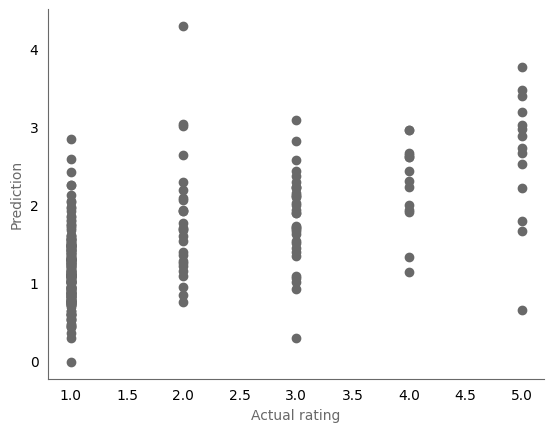

In [26]:
valid_pred = valid_pred.toPandas()

fig, axes = plt.subplots()
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.scatter(valid_pred['rating'], valid_pred['prediction'], color='dimgray')
axes.set_xlabel('Actual rating', fontsize=10, color='dimgray')
axes.set_ylabel('Prediction', fontsize=10, color='dimgray');

## User recommendation
**Key observations:**
* Recommendations are made by making predictions for all movies in the test data (followed by sorting).

  Note: There is no overlap between the ratings history for a user, as given in the training data, and the shortlist of movies in the test data.

In [27]:
# Ratings history in the training data
USER_ID = 11
user_history = training_DF.filter(training_DF['userId']==USER_ID)
user_history.show(10)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|    11|      6|   2.0|1424380312|
|    11|     10|   1.0|1424380312|
|    11|     11|   1.0|1424380312|
|    11|     12|   1.0|1424380312|
|    11|     13|   4.0|1424380312|
|    11|     16|   1.0|1424380312|
|    11|     19|   4.0|1424380312|
|    11|     21|   1.0|1424380312|
|    11|     22|   1.0|1424380312|
|    11|     23|   5.0|1424380312|
+------+-------+------+----------+
only showing top 10 rows



In [28]:
# Recommendations from the test data
print(f"Shortlist of movies in the test data:")
user_shortlist = valid_DF.filter(valid_DF['userId']==USER_ID).select(['movieId', 'userId'])
user_shortlist.show()

print(f"Top 5 recommendations:")
user_recommend = local_model.transform(user_shortlist)
user_recommend.orderBy('prediction', ascending=False).show(5)

Shortlist of movies in the test data:
+-------+------+
|movieId|userId|
+-------+------+
|      0|    11|
|      9|    11|
|     18|    11|
|     20|    11|
|     38|    11|
|     40|    11|
|     48|    11|
|     61|    11|
|     64|    11|
|     70|    11|
|     80|    11|
|     86|    11|
+-------+------+

Top 5 recommendations:
+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|     18|    11| 3.3938375|
|     64|    11| 2.5836756|
|     80|    11| 2.5644124|
|     48|    11| 2.5166395|
|     70|    11| 1.4085507|
+-------+------+----------+
only showing top 5 rows



In [62]:
local_model.write().overwrite().save('./test')

# Google Cloud training
**Key observation:**
* The final model will be trained using all available data. This will be achieved using the Google Cloud platform.

## Data
**Key observation:**
* The data is available in csv form. Consequently, the data prep process will need to be adjusted.

In [29]:
!wc "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/ratings.csv"

 100837  100837 2483723 /content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/ratings.csv


In [30]:
!head -n 5 "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/ratings.csv"

userId,movieId,rating,timestamp
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815


## Training py script

In [80]:
%%writefile "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/als_model.py"
import sys
from math import sqrt
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

INPUT_PATH = sys.argv[1] # parse file path from command line

if __name__ == '__main__':

    # Create SparkContext and SparkSession
    sc = SparkContext(appName="spark-submit demo")
    spark = SparkSession.builder.getOrCreate()

    # 1. Training/test data prep
    rows = spark.read.csv(INPUT_PATH, header=True).rdd
    row_RDD = rows.map(lambda row: Row(userId=int(row[0]), movieId=int(row[1]), rating=float(row[2]), timestamp=int(row[3])))
    ratings_DF = spark.createDataFrame(row_RDD)
    ratings_DF.createOrReplaceTempView('ratings_DF') # register temporary view enabling SQL queries
    (training_DF, valid_DF) = ratings_DF.randomSplit([0.8, 0.2])

    training_DF.write.csv('gs://arctic-crawler-403811-storage/movie_rec_171123_training_DF/', mode="overwrite")
    valid_DF.write.csv('gs://arctic-crawler-403811-storage/movie_rec_171123_test_DF/', mode="overwrite")

    # 2. Baseline
    # Calculate mean rating across all rows in the training set
    SQL_query = 'SELECT AVG(rating) FROM ratings_DF'
    row_baseline = spark.sql(SQL_query).first() # query returns dataframe with only 1 row
    baseline = row_baseline['avg(rating)'] # access via dictionary

    # Calculate squared error for each row in the validation set
    se_RDD = valid_DF.rdd.map(lambda row: Row(se=pow(row['rating']-baseline, 2)))
    se_DF = spark.createDataFrame(se_RDD)
    se_DF.createOrReplaceTempView('se_DF') # register temporary view enabling SQL queries

    # Calculate RMSE
    SQL_query = 'SELECT AVG(se) FROM se_DF'
    row_avg = spark.sql(SQL_query).first() # query returns dataframe with only 1 row
    MSE = row_avg['avg(se)'] # access via dictionary
    print(f"Baseline RMSE: {sqrt(MSE)}")

    # 3. Hyperparameter tuning
    # Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html#pyspark.ml.tuning.ParamGridBuilder
    # Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html#pyspark.ml.evaluation.RegressionEvaluator
    # Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html

    als = ALS(maxIter=10, rank=5, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating") # ALS estimator
    param_grid = ParamGridBuilder().addGrid(als.rank, [15, 20, 25]).addGrid(als.regParam, [0.01, 0.1, 1]).build() # parameter grid
    reg_eval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") # regression evaluator
    k=3
    kfold_cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=reg_eval, numFolds=k) # k-fold cross validation
    cvModel = kfold_cv.fit(training_DF)

    # 4. Save model
    cvModel.write().overwrite().save('gs://arctic-crawler-403811-storage/movie_rec_171123')

    # 5. Evaluation
    param_map = zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics)
    param_min = min(param_map, key=lambda x: x[1])
    print(f"Optimal configuration: {param_min}")
    test_pred = cvModel.transform(valid_DF)
    rmse = reg_eval.evaluate(test_pred)
    print(f"RMSE: {rmse}")

    # Shutdown Spark context
    sc.stop()

Overwriting /content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/als_model.py


## Training via dataproc

**Why Dataproc?**

It allows easy integration with PySpark. With Dataproc, you can easily deploy Spark clusters, scale resources dynamically, and process large-scale data using PySpark, leveraging the power of Spark's distributed computing capabilities for efficient data analysis and processing in a cloud environment.

### Authentication

In [37]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

### Project configuration

In [38]:
PROJECT_ID = "arctic-crawler-403811"
REGION = "us-central1"

# !gcloud projects create $PROJECT_ID
!gcloud config set project $PROJECT_ID
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION
!echo "gcloud config list"
!gcloud config list

Updated property [core/project].
API [compute.googleapis.com] not enabled on project [arctic-crawler-403811]. 
Would you like to enable and retry (this will take a few minutes)? (y/N)?  y

Enabling service [compute.googleapis.com] on project [arctic-crawler-403811]...
Operation "operations/acf.p2-785982552930-5dc1add4-42fc-4179-82b2-819ce2e6b867" finished successfully.
Updated property [compute/region].
Updated property [dataproc/region].
gcloud config list
[component_manager]
disable_update_check = True
[compute]
region = us-central1
[core]
account = billypitchford@gmail.com
project = arctic-crawler-403811
[dataproc]
region = us-central1

Your active configuration is: [default]


### Data upload

In [39]:
# Create storage bucket
BUCKET = f"gs://{PROJECT_ID}-storage"
!gsutil mb $BUCKET
print(BUCKET)

Creating gs://arctic-crawler-403811-storage/...
gs://arctic-crawler-403811-storage


In [46]:
# Copy data to storage bucket
FILEPATH = "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/ratings.csv"
!gsutil -m cp "$FILEPATH" $BUCKET # Enclosed FILEPATH variable in double quotes to handle spaces in path
BUCKET_PATH = BUCKET + "/ratings.csv"
print(BUCKET_PATH)

Copying file:///content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/ratings.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/2.4 MiB.                                      
gs://arctic-crawler-403811-storage/ratings.csv


### Dataproc cluster creation
**Key observations:**

The specific configuration for the cluster is defined in the subsequent options.

* --image-version 1.4-ubuntu18

  Specifies the version of the Dataproc image to be used. In this case, it's using version 1.4 with Ubuntu 18.

* --single-node

  Configures the cluster to have a single master node.

* --master-machine-type n1-standard-2

  Specifies the machine type for the master node. In this case, it's an n1-standard-2 machine type.

* --master-boot-disk-type pd-ssd --master-boot-disk-size 100

  Specifies the type and size of the master node's boot disk. In this case, it's using an SSD disk with a size of 100 GB.

* --max-idle 3600s

  Sets the maximum idle time for the cluster to 3600 seconds (1 hour). If the cluster is idle for this duration, it will be automatically deleted to avoid unnecessary costs.

Note:
* If the cell execution is stopped, the process will still continue in the cloud.

In [48]:
CLUSTER = f"{PROJECT_ID}-cluster"
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --single-node \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd \
    --master-boot-disk-size 100 \
    --max-idle 3600s

API [dataproc.googleapis.com] not enabled on project [arctic-crawler-403811]. 
Would you like to enable and retry (this will take a few minutes)? (y/N)?  y

Enabling service [dataproc.googleapis.com] on project [arctic-crawler-403811]...
Operation "operations/acf.p2-785982552930-1f24650e-ddb6-4ba4-b4f0-c4af11b4a680" finished successfully.
Waiting on operation [projects/arctic-crawler-403811/regions/us-central1/operations/4932393c-ec71-38ce-8e70-174e7b5086ca].

Created [https://dataproc.googleapis.com/v1/projects/arctic-crawler-403811/regions/us-central1/clusters/arctic-crawler-403811-cluster] Cluster placed in zone [us-central1-f].


### Job submission

In [81]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/als_model.py" -- $BUCKET_PATH

Job [b293b851b1374f449cbc439c302d9f62] submitted.
Waiting for job output...
23/11/17 12:54:27 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/11/17 12:54:27 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/11/17 12:54:27 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/11/17 12:54:27 INFO org.spark_project.jetty.util.log: Logging initialized @4168ms to org.spark_project.jetty.util.log.Slf4jLog
23/11/17 12:54:27 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; jvm 1.8.0_312-b07
23/11/17 12:54:27 INFO org.spark_project.jetty.server.Server: Started @4309ms
23/11/17 12:54:27 INFO org.spark_project.jetty.server.AbstractConnector: Started ServerConnector@2b8517a1{HTTP/1.1, (http/1.1)}{0.0.0.0:4040}
23/11/17 12:54:28 WARN org.apache.spark.scheduler.FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure poo

### Downloads

In [84]:
DESTINATION_PATH = "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc"

# Training data
SOURCE_PATH = "gs://arctic-crawler-403811-storage/movie_rec_171123_training_DF"
!gsutil -m cp -r $SOURCE_PATH "$DESTINATION_PATH"

# Test data
SOURCE_PATH = "gs://arctic-crawler-403811-storage/movie_rec_171123_test_DF"
!gsutil -m cp -r $SOURCE_PATH "$DESTINATION_PATH"

# Model
SOURCE_PATH = "gs://arctic-crawler-403811-storage/movie_rec_171123"
!gsutil -m cp -r $SOURCE_PATH "$DESTINATION_PATH"

Copying gs://arctic-crawler-403811-storage/movie_rec_171123_training_DF/_SUCCESS...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123_training_DF/part-00000-023e6046-a302-4ac5-84c6-d26d35821cf8-c000.csv...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123_test_DF/part-00000-9267f650-808f-4429-a560-98bcd0b3ce42-c000.csv...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123_test_DF/_SUCCESS...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123/bestModel/itemFactors/_SUCCESS...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123/bestModel/itemFactors/part-00002-51b611d7-2bcb-4a9c-99fc-fc0744a74b2e-c000.snappy.parquet...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123/bestModel/itemFactors/part-00000-51b611d7-2bcb-4a9c-99fc-fc0744a74b2e-c000.snappy.parquet...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123/bestModel/itemFactors/part-00007-51b611d7-2bcb-4a9c-99fc-fc0744a74b2e-c000.snappy.parquet...
Copying gs://arctic-cra

### Clean up
* To avoid further costs, the cluster and storage buckets are deleted

In [86]:
# Cluster
!gcloud dataproc clusters delete $CLUSTER --region=$REGION

# Storage bucket
BUCKET = "gs://arctic-crawler-403811-storage/"
!gsutil -m rm -r $BUCKET

The cluster 'arctic-crawler-403811-cluster' and all attached disks will be 
deleted.

Do you want to continue (Y/n)?  Y

ERROR: (gcloud.dataproc.clusters.delete) NOT_FOUND: Not found: Cluster projects/arctic-crawler-403811/regions/us-central1/clusters/arctic-crawler-403811-cluster
BucketNotFoundException: 404 gs://arctic-crawler-403811-storage bucket does not exist.
CommandException: Encountered non-existent bucket during listing


## Evaluation

In [89]:
# Test data
TEST_PATH = "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/movie_rec_171123_test_DF/"
TEST_DATA = TEST_PATH + "part-00000-9267f650-808f-4429-a560-98bcd0b3ce42-c000.csv"
!wc "$TEST_DATA"
print("\n")
!head -n 5 "$TEST_DATA"

 20066  20066 474297 /content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/movie_rec_171123_test_DF/part-00000-9267f650-808f-4429-a560-98bcd0b3ce42-c000.csv


1,2.0,939114353,412
1,2.5,1391736605,528
1,3.0,847221025,609
1,3.0,853937855,214
1,3.0,855583216,529


In [105]:
# Read test data into spark DataFrame
test_DF = spark.read.csv(TEST_DATA).withColumnRenamed("_c0", "userId") \
                                    .withColumnRenamed("_c1", "rating") \
                                    .withColumnRenamed("_c2", "timestamp") \
                                    .withColumnRenamed("_c3", "movieID")
test_DF.show(5)
test_DF.printSchema()

+------+------+----------+-------+
|userId|rating| timestamp|movieID|
+------+------+----------+-------+
|     1|   2.0| 939114353|    412|
|     1|   2.5|1391736605|    528|
|     1|   3.0| 847221025|    609|
|     1|   3.0| 853937855|    214|
|     1|   3.0| 855583216|    529|
+------+------+----------+-------+
only showing top 5 rows

root
 |-- userId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- movieID: string (nullable = true)



In [114]:
# Cast relevant dtypes
from pyspark.sql.types import LongType, DoubleType
test_DF = test_DF.withColumn("userId", test_DF["userId"].cast(LongType())) \
                  .withColumn("rating", test_DF["rating"].cast(DoubleType())) \
                  .withColumn("movieId", test_DF["movieId"].cast(LongType())) \
                  .withColumn("timestamp", test_DF["timestamp"].cast(LongType()))
test_DF.printSchema()

root
 |-- userId: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- movieId: long (nullable = true)



In [115]:
# Read pickled model
from pyspark.ml.tuning import CrossValidatorModel
MODEL_PATH = "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/movie_rec_171123"
gcloud_model = CrossValidatorModel.load(MODEL_PATH)

In [116]:
# Evaluate
test_pred = gcloud_model.bestModel.transform(test_DF)
reg_eval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
test_rmse = reg_eval.evaluate(test_pred)

print(f"RMSE: {test_rmse}")
print("_"*50, "\n"*2)
test_pred.show()

RMSE: nan
__________________________________________________ 


+------+------+----------+-------+-----------+
|userId|rating| timestamp|movieId| prediction|
+------+------+----------+-------+-----------+
|     1|   2.0| 939114353|    412|   0.868865|
|     1|   2.0| 939114353|    412|   2.398054|
|     1|   2.0| 939114353|    412|  1.4572092|
|     1|   2.0| 939114353|    412|  3.0852547|
|     1|   2.5|1391736605|    528|  2.5351605|
|     1|   2.5|1391736605|    528|  1.5402652|
|     1|   2.5|1391736605|    528|  2.4358478|
|     1|   2.5|1391736605|    528|  2.0843716|
|     1|   3.0| 847221025|    609|  4.5355363|
|     1|   3.0| 847221025|    609|  3.9269233|
|     1|   3.0| 847221025|    609|  4.8908095|
|     1|   3.0| 847221025|    609|   3.749262|
|     1|   3.0| 853937855|    214|  0.5435827|
|     1|   3.0| 853937855|    214|  1.9331222|
|     1|   3.0| 853937855|    214|-0.21802905|
|     1|   3.0| 853937855|    214|  1.1318959|
|     1|   3.0| 855583216|    529|  4.73544

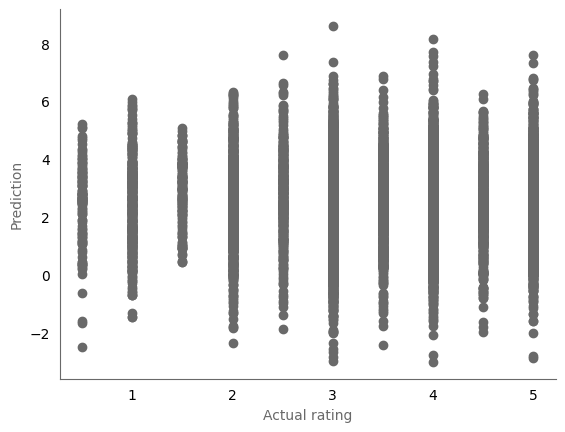

In [117]:
test_pred = test_pred.toPandas()

fig, axes = plt.subplots()
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.scatter(test_pred['rating'], test_pred['prediction'], color='dimgray')
axes.set_xlabel('Actual rating', fontsize=10, color='dimgray')
axes.set_ylabel('Prediction', fontsize=10, color='dimgray');

## User recommendation